In [19]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt

In [13]:
# load the image and labels
images = np.load("./cs475_project_data/images.npy")
labels = np.load("./cs475_project_data/labels.npy")
num_imgs, height, width = images.shape
images = images.reshape(num_imgs, height*width) # transform each image to a height*width dimension vector

# separate out apple class
X = torch.Tensor(images.copy().astype(float))
Y = torch.Tensor(labels.copy().astype(float))
is_apple = Y == 0
not_apple = ~is_apple
Y[is_apple] = 1 # label 1 for class 0 (apple), 10000 total
Y[not_apple] = 0 # label 0 for other calsses (non-apple) ,  40000 total

# separate training, cross-validation and testing data (40000:5000:5000)
train_X, cross_X, test_X = X[:40000], X[40000:45000], X[45000:] # FloatTensors
train_Y, cross_Y, test_Y = Y[:40000], Y[40000:45000], Y[45000:]

[1,   100] loss: 0.362
train_temp_accu= 0.87200
cross_temp_accu= 0.88800
w_arr_id= 0



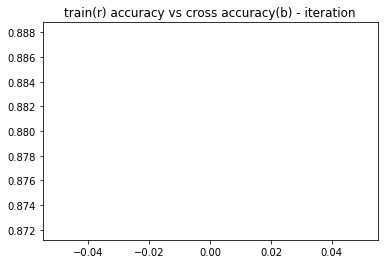

[1,   200] loss: 0.181
train_temp_accu= 0.93100
cross_temp_accu= 0.94100
w_arr_id= 1



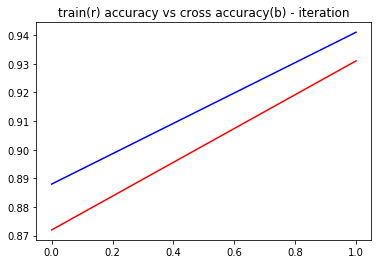

KeyboardInterrupt: 

In [31]:
class LogisticRegression(object):
    def __init__(self):
        super().__init__()
        self.w = None
        self.lr = None
        self.train_accu = None
        self.cross_accu = None
        self.w_arr = None
        
            
    def predict_accuracy(self, X, Y, size):
        rand_index = torch.LongTensor(np.random.randint(0, len(X), size))
        X = Variable(X.index(rand_index), requires_grad=True)
        Y = Variable(Y.index(rand_index), requires_grad=True)
        Y_hat = self.predict(X)
        accu = self.accuracy(Y, Y_hat)
        return accu
            
        
    def predict(self, X):
        #print("in predict, X=", type(X), X.data.shape, ",w=", type(self.w), self.w.data.shape)
        if self.w is None:
            raise Exception('fit must be called before predict.')
        
        mean = torch.mean(X, 1) # mean of each row
        X = (X - (mean.view(mean.size(0), 1))) / 255 # subtract mean and normalize to 1
        
        Y_hat = torch.sigmoid(X @ self.w)
        Y_hat[Y_hat >= 0.5] = 1
        Y_hat[Y_hat < 0.5] = 0
        return Y_hat
    
    
    def accuracy(self, y, y_hat):
        """Compute accuracy.
        Args:
           y: A 1-D int NumPy array.
           y_hat: A 1-D int NumPy array.
        Returns:
           A float, the fraction of time y[i] == y_hat[i].
        """
        return torch.mean((y == y_hat).float())   
        
        
    def fit(self, X, Y, lr, num_iter):
        self.lr = lr
        X, Y = Variable(X, requires_grad=True), Variable(Y, requires_grad=True) # here X/Y is the train_X/Y dataset
        num_examples, num_features = X.data.shape
        w = Variable(torch.rand(num_features), requires_grad=True) # Variable of FloatTensor
        
        self.train_accu = []
        self.cross_accu = []
        self.w_arr = []
        w_arr_id = 0
        for k in range(num_iter):
            running_loss = 0.0
            for i in range(num_examples):
                x = X[i] # 676/40000 * 676
                y = Y[i] # 1/40000
                
                mean = torch.mean(x)
                x = (x - mean) / 255
                
                #product = torch.clamp(w.dot(x), min = -88, max = 9)
                product = w.dot(x)
                loss = -y * torch.log(torch.sigmoid(product)) - (1 - y) * torch.log(1 - torch.sigmoid(product))
                loss.backward()
                w.data = w.data - lr * w.grad.data 
                w.grad.data.zero_()
                
                # print statistics
                running_loss += loss.data[0]
                if i % 100 == 99: 
                    self.w = w
                    print('[%d, %5d] loss: %.3f' % (k + 1, i + 1, running_loss/100))
                        
                    train_temp_accu = self.predict_accuracy(train_X, train_Y, 1000)
                    print("train_temp_accu= %.5f" % train_temp_accu.data[0])
                    self.train_accu.append(train_temp_accu.data[0])
                    
                    cross_temp_accu = self.predict_accuracy(cross_X, cross_Y, 1000)
                    print("cross_temp_accu= %.5f" % cross_temp_accu.data[0])
                    self.cross_accu.append(cross_temp_accu.data[0])
                    
                    
                    print("w_arr_id=", w_arr_id)
                    self.w_arr.append(w)
                    w_arr_id += 1
                    running_loss = 0.0
                    print("")
                    
                    plt.clf()
                    plt.plot(self.train_accu, 'r-')
                    plt.plot(self.cross_accu, 'b-')
                    plt.title("train(r) accuracy vs cross accuracy(b) - iteration")
                    plt.show()
            
lgrg = LogisticRegression()
lgrg.fit(train_X, train_Y, 0.1, 3)

print("Finished Training")

In [30]:
# plot training accuracy as a function of iteration
plt.plot(lgrg.train_accu, 'r-')

# plot validation accuracy as a function of iteration
plt.plot(lgrg.cross_accu, 'b-')

**Q: Overfitting here?**

A: